In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext Cython
import os
# Run on CPU so it doesn't conflict with code running on GPU
os.environ['THEANO_FLAGS'] = 'device=cpu'  
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import cPickle
from collections import defaultdict, OrderedDict

import buildmodel
from getactivations import get_noiselayer_activations, trn, tst

import seaborn as sns
sns.set_context("paper")
nats2bits = 1./np.log(2)

    
def entropy(p):
    lp = np.log(p)
    lp[p==0] = 0.0
    return -p.dot(lp)

doSave = False # whether to save output PDFs

Using Theano backend.


In [2]:
# Load dictionaries
BASE_DIR = 'models'
saved_dict_base = OrderedDict()
for fname in os.listdir(BASE_DIR):
    if not fname.startswith('savedhist'):
        continue
    with open(BASE_DIR+'/'+fname, 'rb') as f:
        d = cPickle.load(f)
        beta = d['args']['beta']
        if beta >= 1e-1 and not np.isclose(beta,0):
            fsfx = fname[len('savedhist-'):-len('.dat')]
            print 'Loading', fsfx
            
            # Load Monte Carlo entropy estimate files (generated by compute_mc_mi.py)
            mcfile = BASE_DIR+'/mcentropy-'+fsfx+'.dat'
            if os.path.exists(mcfile):
                with open(mcfile) as fmc:
                    d['mc'] = cPickle.load(fmc)
                
            mode = d['args']['mode']
            arch = d['args']['encoder']+'-'+d['args']['decoder']
            
            saved_dict_base[fsfx] = d

Loading nlIB-800-800-2-800-0.400000
Loading nlIB-800-800--0.700000
Loading vIB-800-800-20-800-0.900000
Loading nlIB-800-800-20-800-0.700000
Loading regular-800-800-2--0.500000
Loading nlIB-800-800-20-800-0.300000
Loading vIB-800-800-2-800-0.700000
Loading nlIB-800-800-2-800-0.900000
Loading nlIBnokde-800-800-20-800-0.800000
Loading nlIB-800-800--0.800000
Loading vIB-800-800-20-800-0.600000
Loading vIB-800-800-2-800-0.650000
Loading nlIB-800-800-20-800-0.800000
Loading nlIB-800-800-20-800-0.750000
Loading nlIB-800-800-20-800-0.400000
Loading nlIB-100-100-2-100-0.650000
Loading vIB-800-800-2-800-0.900000
Loading nlIB-800-800-20-800-0.900000
Loading nlIB-800-800-2-800-0.750000
Loading vIB-800-800-2-800-0.600000
Loading nlIB-800-800-2-800-0.700000
Loading vIB-800-800-2-800-0.500000
Loading nlIB-800-800-20-800-0.600000
Loading vIB-800-800-20-800-0.400000
Loading vIB-800-800-2-800-0.750000
Loading nlIBnokde-800-800-20-800-0.500000
Loading nlIBnokde-800-800-20-800-0.600000
Loading nlIBnokde-8

nlIB-800-800-2-800
nlIB-800-800-2-800
nlIB-800-800-
nlIB-800-800-
vIB-800-800-20-800
vIB-800-800-20-800
nlIB-800-800-20-800
nlIB-800-800-20-800
regular-800-800-2-
regular-800-800-2-
nlIB-800-800-20-800
vIB-800-800-2-800
vIB-800-800-2-800
nlIB-800-800-2-800
nlIBnokde-800-800-20-800
nlIBnokde-800-800-20-800
nlIB-800-800-
vIB-800-800-20-800
vIB-800-800-2-800
nlIB-800-800-20-800
nlIB-800-800-20-800
nlIB-800-800-20-800
nlIB-100-100-2-100
nlIB-100-100-2-100
vIB-800-800-2-800
mc not found
nlIB-800-800-20-800
nlIB-800-800-2-800
vIB-800-800-2-800
nlIB-800-800-2-800
vIB-800-800-2-800
nlIB-800-800-20-800
vIB-800-800-20-800
vIB-800-800-2-800
nlIBnokde-800-800-20-800
nlIBnokde-800-800-20-800
nlIBnokde-800-800-20-800
vIB-800-800-20-800
mc not found
vIB-800-800-4-800
vIB-800-800-4-800
nlIB-800-800-2-800
nlIB-100-100-2-
nlIB-100-100-2-
nlIB-800-800-
vIB-800-800-20-800
nlIB-800-800-20-800
nlIB-800-800-
nlIB-800-800-20-800
vIB-800-800-20-800
vIB-800-800-2-800
nlIBnokde-100-100-2-
nlIBnokde-100-100-2-
vI

KeyError: 'mc'

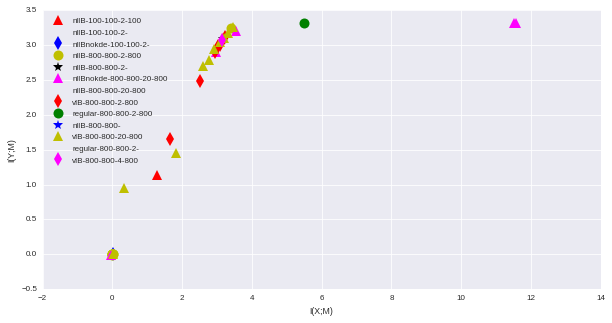

In [4]:
# Plot MC entropy values values
import itertools
marker = itertools.cycle(('^', '+', 'd', 'o', '*')) 
if True:
    plot_phase = 'trn'
    #plot_phase = 'tst'
    plotmc = defaultdict(list)
    for k,v in saved_dict_base.iteritems():
        cK = k[0:-len("-0.000000")]
        if cK not in plotmc:
            print cK
        print cK
        if 'mc' not in v:
            print 'mc not found'
            continue
        plotmc[cK].append((v['mc'][plot_phase], v['endlogs']['loss_mi_'+plot_phase]))
    plt.figure(figsize=(10,5))
    plt.rc('axes', color_cycle=['r', 'g', 'b', 'y','k','magenta','brown'])
    for ndx, (k, v) in enumerate(plotmc.iteritems()):
        xs,ys= map(np.array, zip(*v))
        plt.plot(nats2bits*xs, nats2bits*ys, next(marker),markersize=10, label=k)
        plt.hold('on')
    plt.xlabel('I(X;M)')
    plt.ylabel('I(Y;M)')

    plt.legend(loc='upper left')
    #plt.ylim([2,2.7]); plt.xlim([2,2.7])
    #asdf
    mi_mc = {}
    mi_xm2 = {}
    mi_ym2 = {}
    plot_modes = ['nlIB-800-800-20-800-','vIB-800-800-20-800-']
    for plot_mode in plot_modes:
        dicts = [v for k, v in saved_dict_base.iteritems() if k.startswith(plot_mode)]

        mi_xm2[plot_mode] = {}
        mi_ym2[plot_mode] = {}

        mi_mc[plot_mode] = {}
        for phase in ['trn','tst']:
            mi_mc[plot_mode][phase]  = nats2bits * np.array([d['mc'][phase] for d in dicts])
            mi_xm2[plot_mode][phase] = nats2bits * np.array([d['endlogs']['mi_'+phase] for d in dicts])
            mi_ym2[plot_mode][phase] = nats2bits * np.array([d['endlogs']['loss_mi_'+phase] for d in dicts])
            betavals = np.array([d['args']['beta'] for d in dicts])

    sortorder = np.argsort(betavals)
    plot_phase = 'tst'
    with sns.axes_style("whitegrid"):
        plt.figure() #figsize=(7,2))
        plt.locator_params(nbins=6)
        marker_styles = ['o:','o--','o.']
        for ndx, cmode in enumerate(plot_modes):
            plt.plot(mi_mc[cmode][plot_phase][sortorder], 
                     mi_ym2[cmode][plot_phase][sortorder], 
                     marker_styles[ndx], label=cmode)

        #plt.plot(mi_mc['nlIB'][plot_phase], mi_mc['nlIB'][plot_phase], '.')
        plt.xlabel('I(X;M)')
        plt.ylabel('I(Y;M)')
        leg=plt.legend(loc='lower right', frameon=True)
        #leg.get_frame().set_alpha(1.0)
        leg.get_frame().set_edgecolor('k')    

    plt.tight_layout()
    #plt.savefig('out1.pdf', bbox_inches='tight')
    


In [ ]:
plot_mode = 'nlIBnokde-800-800-20-800-'
#plot_mode = 'nlIBnokde-800-800-20-800-'
#plot_mode = 'vIB-800-800-20-800-'
current_palette = sns.color_palette('muted')
sns.set_palette(current_palette)

dicts = [v for k, v in saved_dict_base.iteritems() if k.startswith(plot_mode)]
betavals = np.array([d['args']['beta'] for d in dicts])
sortorder = np.argsort(betavals)
betavals = betavals[sortorder]

mi_xm, mi_ym = {}, {}
for phase in ['trn','tst']:
    mi_xm[phase] = np.array([nats2bits*d['endlogs']['mi_'+phase] for d in dicts])[sortorder]
    mi_ym[phase] = np.array([nats2bits*d['endlogs']['loss_mi_'+phase] for d in dicts])[sortorder]

symbols = {'trn':'v','tst':'^'}
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(7,2))

    plt.subplot(1,3,1)
    plt.locator_params(nbins=6)
    for phase in ['trn','tst']:
        plt.plot(mi_xm[phase], mi_ym[phase], symbols[phase]+'-')
    plt.xlabel('I(X;M)')
    plt.ylabel('I(Y;M)')
    
    
    plt.subplot(1,3,2)
    plt.locator_params(nbins=6)
    for phase in ['trn','tst']:
        plt.plot(betavals, mi_ym[phase], symbols[phase]+'-')
    plt.xlabel(u'β')
    plt.ylabel('I(Y;M)')
    plt.hold('on')
    plt.plot(betavals, np.zeros(len(betavals))+np.log2(10),'k--')
    print mi_ym['trn'], '*****'
    plt.ylim([0, 1.1*max(mi_ym['trn'].max(),mi_ym['tst'].max())])
    plt.xlim([betavals.min(), betavals.max()])
    
    leg=plt.legend(['Train','Test', 'H(Y)'], loc='lower left', frameon=True)
    leg.get_frame().set_edgecolor('k')

    plt.subplot(1,3,3)
    plt.locator_params(nbins=6)
    for phase in ['trn','tst']:
        plt.plot(betavals, mi_xm[phase], symbols[phase]+'-')
    plt.xlabel(u'β')
    plt.ylabel('I(X;M)')
    plt.hold('on')
    plt.plot(betavals, np.zeros(len(betavals))+np.log2(10),'k--')
    plt.xlim([betavals.min(), betavals.max()])
    plt.ylim([0, 1*max(mi_xm['trn'].max(),mi_xm['tst'].max())])
    
plt.tight_layout()

if doSave:
    plt.savefig('imgs/out_%s.pdf'%plot_mode, bbox_inches='tight')

In [ ]:
current_palette = sns.color_palette('hls')
sns.set_palette(current_palette)
# construct cmap
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(current_palette)

#plot_names = ['nlIB-800-800-2-800-0.400000','regular-800-800-2-800-0.500000']
#plot_names = ['nlIB-800-800--0.700000','regular-800-800-2-800-0.500000']
#plot_names = ['nlIB-800-800-2--0.400000','regular-800-800-2--0.500000']
plot_names = ['nlIB-800-800-2-800-0.400000']
#plot_names = ['regular-800-800-2--0.500000']

with sns.axes_style("whitegrid"):
    plt.figure(figsize=(6,2.5))
    sndx = 1.
    for fname in plot_names:
        arg_dict = saved_dict_base[fname]['args']

        plt.subplot(1,2,sndx);sndx+=1
        pltX, colors = trn.X, trn.y
        #pltX, colors = tst.X, tst.y
        activations, _ = get_noiselayer_activations(arg_dict, fname, pltX)
        activations -= activations.min(axis=0)
        activations /= activations.max(axis=0)

        plt.scatter(activations[:,0], activations[:,1],
                    edgecolor='none', 
                    s=4, c=colors,
                   alpha=0.1,cmap=my_cmap) 
        sns.set_palette(current_palette)
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])

#plt.savefig('imgs/hidden.pdf', bbox_inches='tight')

            
